In [125]:
import torch
from torch import Tensor
import numpy as np

# Suggestion on Naming

    layer_par    :  Layer    (it's a class)
    forward_par  :  Forward  (class)
    backward_par :  Backward (class)
    
    
    make_arch    :  makeArhc (it's a method in Net class)
    forward_list :  fw_list  (attribute list)
    backward_list:  bw_list  (attribute list)
    

# Auxiliary Classes

In [126]:
class Linear:
    """
    An class that contains objects which only store layar's in/out connections dimension
    
    input_s:
        dim_in      :  the input_ dimension of fully connected layer
        dim_out     :  the output_ dimension of fully connected layer
        
    returns:
        Nothing 
    """
    
    def __init__(self,dim_in, dim_out):
        self.input_ = dim_in
        self.output_ = dim_out          
    # TODO: The linear is really wierd thing... all we get here is already in the upper class. we may omit this somehow

#---------------------------------------------------------------------------------------------
        
def Activation(code,input_):
    """
    A class that specify the needed activation with respect to the following code conversion
        0: Relu(x)
        1: Tanh(x)
        2: Sigmoid(x)
    
    This class works as functional package of pytorch
    
    input_s:
        code        :  the code for each activation (0,1,2)
        input__tensor:  the input_ tensor
        
    returns:
        result      :  the output_ of requested activation function with the same shape as input_ tensor
    """
    result = Tensor(input_.shape)
    # Relu
    if code ==0:
        result = input_ - (input_<0).float()*input_
    # Tanh
    elif code ==1:
        result = torch.tanh(input_)
    # Sig
    elif code ==2:
        result = 1.0/(1 + torch.exp(-input_))
    # linear
    elif code ==3:
        result = input_
    # error
    else: raise ValueError('Unknown Code For Activation')
        
    return result 

#---------------------------------------------------------------------------------------------

def dActivation(code,input_):
    """
    A class that specify the needed derivative of activation with the same encoding convenstion
        0: dRelu(x)
        1: dTanh(x)
        2: dSigmoid(x)
    
    This class works as functional package of pytorch
    
    input_s:
        code        :  the code for each activation (0,1,2)
        input__tensor:  the input_ tensor
        
    returns:
        result      :  the output_ of requested activation function with the same shape as input_ tensor
    """
    result = Tensor.new(input_)
    # dRelu
    if code ==0:
        result = Tensor(input_.shape).fill_(1.0) - (input_<=0).float()*Tensor(input_.shape).fill_(1.0)
    # dTanh
    elif code ==1:
        result = 1-(torch.tanh(input_))**2
    # dSig
    elif code ==2:
        result = Activation(code,input_)*(1-Activation(code,input_))
    # linear
    elif code ==3:
        result = Tensor(input_.shape).fill_(1.0)
    else: raise ValueError('Unknown Code For derivative of Activation')
    
    return result 

#---------------------------------------------------------------------------------------------
    
class PassPar:    # change the name to: "ForwardAns
    """
    This class keeps track of all the variables produced in forward pass of some layer. i.e, x and s.
    
    inputs:
        N           :  number of data
        dim_in      :  the input_ dimension of fully connected layer
        dim_out     :  the output_ dimension of fully connected layer
        
    returns:
        Nothing
    """
    def __init__(self,dim_in, dim_out, N):
        self.s = Tensor(N,dim_out).fill_(0)           # s after each layer
        self.x = Tensor(N,dim_out).fill_(0)           # x after each layer:   x = Activation (s)
        self.db = Tensor(N, dim_out,1).fill_(0)       # dL/db for each input
        self.dw = Tensor(N, dim_out,dim_in).fill_(0)  # dL/dw for each input
        self.ds = Tensor(N, dim_out).fill_(0)         # dL/ds for each input
        self.dx = Tensor(N, dim_out).fill_(0)         # dL/dx for each input
        
#---------------------------------------------------------------------------------------------

class Param:
    """
    This class contains parameters of each layer. We initialize them in constructor.
    
    inputs:
        dim_in      :  the input dimension of fully connected layer
        dim_out     :  the output dimension of fully connected layer
        b           :  bias vector
        w           :  weight matrix
        db          :  grad wrt bias
        dw          :  grad wrt weight matrix
    modules:
        data        :  returns the parameters as one tensor 
        grad        :  returns the grad of Loss wrt to parameter as one tensor
    """
    def __init__(self, dim_in, dim_out):
        self.dim_in  = dim_in
        self.dim_out = dim_out
        self.b = Tensor(dim_out,1).fill_(0)          # bias of each layer
        self.w = Tensor(dim_out,dim_in).normal_()    # w of each layer
        self.db = Tensor(dim_out,1).fill_(0)         # dL/dbias of each layer
        self.dw = Tensor(dim_out,dim_in).normal_()   # dL/dw of each layer
    
    
    def data(self):
        return (torch.cat((self.w, self.b),1))
    
    def grad(self):
        return (torch.cat((self.dw.t(), self.db),1))

# Loss: MSE

In [127]:
def loss(v, t):
    l_ = torch.sum(torch.pow(v-t,2))/(len(v))
    return l_

def dloss(v,t):
    return 2.*(v-t)


# Network Class

In [128]:
class Net:
    """
    The network class. It has the following methods:
        param      :  returns the parameter which is asked for. Not the data! The object... 
                        Data is accessible through object.data method)
        make_arch  :  makes the architecture of the network by taking a sequential list of [fc1,act1,fc2,act2,...]
    """
    
    def __init__(self, seq,X,Y=None):
        
        self.N = len(X)                                     # nb of batch
        self.n_layer =len(seq)//2                           # number of layer  ((*/2) is because of the activations...)
        
        self.param_list    = list(range(self.n_layer))      # Stores parameters of each layer (W,b) and their grads  
        self.pass_list     = list(range(self.n_layer+1))    # Stores parameters evaluted during forward/backward pass
        
        self.act_list = list(range(self.n_layer))           # stores the requested activation functions in codes. Elements are "0","1" or "2"
        self.make_arch(seq)                                 # makes the architecture based on the the list "seq"
        

    def make_arch(self,seq):    # makeArch
        """
        This function fills param_list and act_list and also, evaluates number of layers.
        
        input:
            seq : a list that contains both activation and layers in a sequential manner
                  Example: [Linear(3,5), 'relu', Linear(5,64), 'Sig', Linear(64,1), 'Tanh']
        """
        
        seq_len = len(seq)                  # number of layer *2 (because of the activations...)
        for layer in list(range(0,seq_len,2)):
             
            # seq[layer] is an instance of object "Linear". Here we get the in/out dim of the layer
            dim_in, dim_out = seq[layer].input_ , seq[layer].output_ 
            
            # making a new Param instance and adding it to the param_list
            self.param_list[int(layer/2)]= Param(dim_in, dim_out) 
            
            # activation recognition : encode activations in "act_list"
            if seq[layer+1]=='relu':
                self.act_list.append(0)
            elif seq[layer+1]=='tanh':
                self.act_list.append(1)
            elif seq[layer+1]=='sig':
                self.act_list.append(2)
            elif seq[layer+1]=='lin':
                self.act_list.append(3)
            else: raise ValueError('Unknown Activation')
                    
    
    def forward(self,X): 
        """
        This method evaluates the forward pass and returns the values. This function is written such that it take a
        batch input and returns the forward pass of the batch.
        
        input: 
            X    :   a tensor of size(B, d_in) 
            
        returns:
            s    :   a tensor of size(B, d_out) 
            x    :   a tensor of size(B, d_out) 
        """
        
        x=X
        for layer, prm in enumerate(self.param_list):   # layer = [0,1,2,...,nb_layer -1]  ;  prm = param_list[layer]
            s = (x.mm(prm.w.t()) + prm.b.t())           # written consistant for batch :  s = (Wx+b).t()  (N,d_out) 
            x = Activation(self.act_list[layer], s)     # size = (N,d_out)       
        return x,s
    
        """
        Hint:
            prm.w.shape = (d_out, d_in)
            prm.b.shpae = (d_out, 1)
            X.shape     = (N,d_in)
            x.shape     = (N,d_out)
            s.shape     = (N.d_out)
        """
    
    
    def backward (self,X,Y):
        """
        This method fills pass_list by constructing instances of PassPar.The object PassPar, contains
        (s,x) and also the gradients with respect to all parameteres of each layer (dL/dw, dL/db, dL/ds, dL/dx)
        during a froward and backwar pass.
        
        These gradients are responsible for all batch data. The sum of all parameters determines the
        total gradient of the batch. This summation is stored in the respective attributes of param_list that 
        contains Param objects.
        
        This function return the values of MSE loss during each pass.
        
        input:
            X        :   training set of size (B,d)
            Y        :   target set of size (B,d)
            
        returns:
            loss     :   value of MSE loss
        """
        
        # add the input X to the pass list
        self.pass_list[0]= PassPar(self.param_list[0].dim_in, self.param_list[0].dim_in, self.N)    # Note that dim = dim_in for inputs
        self.pass_list[0].x =X    # x0
        self.pass_list[0].s =X    # s0 is set to be x0
        
        
        # this computes forward pass and saves s and x
        x=X
        for layer, prm in enumerate(self.param_list): # layer = [0,1,2,...,nb_layer -1]  ; prm = param_list[layer]  
            
            """
            hint: PassPar has following attributes:
                s  = Tensor(N, dim_out)           
                x  = Tensot(N, dim_out)
            """
            
            self.pass_list[layer+1]= PassPar(prm.dim_in, prm.dim_out, self.N)  # instantiating pass parameters
            
            #print('hey there and shape of pass_list[layer+1].dw is {}'.format(self.pass_list[layer+1].dw.shape))
            
            s = (x.mm(prm.w.t()) + prm.b.t())         # consistant with batch. s.shape = (N,d_out)
            self.pass_list[layer+1].s = s             
            x = Activation(self.act_list[layer], s)    
            self.pass_list[layer+1].x = x
         
        
        # this computes backward
        for layer in list(range (self.n_layer,0,-1)): # layer=[nb_layer, nb_layer-1 , ..., 1]
            
            """
            hint: PassPar also has the following attributes:
                db = Tensor(N, dim_out,1)         # dL/db
                dw = Tensor(N, dim_out,dim_in)    # dL/dw
                ds = Tensor(N, dim_out)           # dL/ds
                dx = Tensor(N, dim_out)           # dL/dx
            """
            
            # dl/dx : size = N,d_out
            if layer == self.n_layer:
                self.pass_list[layer].dx = dloss(x,Y)   
            else:
                self.pass_list[layer].dx = self.pass_list[layer+1].ds.mm(self.param_list[layer].w)
            """
            hint:
                dloss(x,Y)                 = (N, d_out_{last_layer})
                pass_list[layer+1].ds      = (N, d_out_{layer+1})
                param_list[layer].w        = (d_out_{layer+1}, d_in_{layer+1}) = (d_out_{layer+1}, d_out_{layer}) 
            """
                
                
            #dl/ds : size = N,d_out
            self.pass_list[layer].ds = self.pass_list[layer].dx * dActivation(self.act_list[layer-1], self.pass_list[layer].s ) 
            """
            hint:
                self.act_list[layer-1] :  activation type of layer = layer (0,1,2 or 3)
                pass_list[layer].dx    =  (N, d_out)
                pass_list[layer].s     =  (N, d_out)
                pass_list[layer].ds    =  (N, d_out)
                dActivation(code, s)   =  (N, d_out)
            """
            
            
            #dl/dw : size = (N, d_out, d_in)
            ds_unsq = self.pass_list[layer].ds.unsqueeze(1)    
            x_unsq  = self.pass_list[layer-1].x.unsqueeze(2)
            self.pass_list[layer].dw =  (x_unsq * ds_unsq).transpose(1,2)         
            """
            hint:
                pass_list[layer].ds        = (N, d_out)
                self.pass_list[layer-1].x  = (N, d_in)
                ds_unsq                    = (N, 1, d_out)
                dx_unsq                    = (N, d_in, 1)
                pass_list[layer].dw        = (N, d_out, d_in)
            """
            
            
            #dl/db : size = (N, d_out)
            self.pass_list[layer].db = self.pass_list[layer].ds
            
            """
            hint:
                pass_list[layer].ds        = (N, d_out)
                pass_list[layer].db        = (N, d_out)
            """
           
        
        # summing all batch grads
        for layer in list (range(0,self.n_layer)):
            self.param_list[layer].db = self.pass_list[layer+1].db.sum(0).unsqueeze(1)/self.N  
            self.param_list[layer].dw = self.pass_list[layer+1].dw.sum(0)/self.N   
            #print('hey there in sum and shape of pass_list[layer+1].dw is {}'.format(self.pass_list[layer+1].dw.shape))
            
        
        # evaluating loss: Not crucial 
        L = loss(x,Y)   
        return L
        
    
    
    def parameteres (self):
        return self.param_list
        
    
    def train(self,X,Y,eta,thresh):
        L0=0
        while True:
            L=self.backward(X,Y)
            if (abs(L-L0)<thresh):
                break
            L0=L
            print('Loss value is {}'.format(L))
            
            for p in self.parameteres():
                p.b -= eta* p.db
                p.w -= eta* p.dw


# Notes for Ehsan

Backward now doesn't return anything! but you can access the parametes and the grads of each layer using the following
    
    model.parameteres

This returns a list with length = nb_of_layers, starting from 0 and ending at L-1. Here is simple example, using our usual hand-made batch.

  

In [129]:
x = Tensor(7).normal_()
X = torch.cat((x.view(1,-1),x.view(1,-1)*3,x.view(1,-1)*x.view(1,-1)),0)
Y= Tensor(3,10).normal_();

In [130]:
seq = [Linear(7,2),'lin',Linear(2,5),'relu',Linear(5,10),'lin']    
model = Net(seq,X,Y)

In [131]:
model.backward(X,Y)         

11.158918181754416

In [132]:
#print(model.parameteres()[1].data())
model.train(X,Y,0.001,0.001)
#print(model.parameteres()[1].data())

Loss value is 11.158918181754416
Loss value is 11.141458016587421
Loss value is 11.123009154888374
Loss value is 11.103602052928181
Loss value is 11.083298811601708
Loss value is 11.062196656518305
Loss value is 11.040430999006881
Loss value is 11.018174603838512
Loss value is 10.99563050205082
Loss value is 10.97302416031016
Loss value is 10.950590104063545
Loss value is 10.928557550025289
Loss value is 10.907133436048753
Loss value is 10.886495012266096
Loss value is 10.86677717032515
Loss value is 10.848073202131976
Loss value is 10.830436629791317
Loss value is 10.813883348581536
Loss value is 10.798400305618998
Loss value is 10.78395175334299
Loss value is 10.770486881713927
Loss value is 10.757945715546763
Loss value is 10.746261462937886
Loss value is 10.735367602038119
Loss value is 10.725198463750226
Loss value is 10.715690125216497
Loss value is 10.706783767896317
Loss value is 10.698423304488339
Loss value is 10.690559046187749
Loss value is 10.683143861640323
Loss value is 

Loss value is 9.785557327966671
Loss value is 9.784420559473801
Loss value is 9.783284708139641
Loss value is 9.782150723583376
Loss value is 9.781017547473311
Loss value is 9.779885609964063
Loss value is 9.778755180751128
Loss value is 9.777625857988218
Loss value is 9.776497790376501
Loss value is 9.775370935890047
Loss value is 9.774245468569765
Loss value is 9.773121073861452
Loss value is 9.77199835452484
Loss value is 9.770876011093302
Loss value is 9.76975580669629
Loss value is 9.768636703898665
Loss value is 9.767518484945564
Loss value is 9.766401532047894
Loss value is 9.765286144334823
Loss value is 9.76417125974937
Loss value is 9.763058442389593
Loss value is 9.76194631314138
Loss value is 9.760835445777047
Loss value is 9.759725949979233
Loss value is 9.75861768325558
Loss value is 9.757510628687063
Loss value is 9.756404695333913
Loss value is 9.755300459063923
Loss value is 9.754197141233211
Loss value is 9.753094691802593
Loss value is 9.751993479886247
Loss value is

# Test : It should be written in another file

In [133]:
N=1000             # number of points
x=torch.rand(N)    # x pos
y=torch.rand(N)    # y pos

input_=Tensor(N,2)       # input batch
target_=Tensor(N,2)      # target batch
input_[:,0]=x
input_[:,1]=y

#r=1/(2*math.pi) #r^2
r=1

# making a hot vector target
target_[:,0]= (x**2 + y**2 <=r).float() - ( x**2 + y**2 > r).float()   # 1 if inside circle, else -1
target_[:,1]= (x**2 + y**2 > r).float() - ( x**2 + y**2 <=r).float()   # -1 if inside circle else 1

In [134]:
seq = [Linear(2,25),'tanh',Linear(25,25),'tanh',Linear(25,25),'tanh',Linear(25,2),'tanh']    
model = Net(seq,input_,target_)

In [144]:
model.train(input_,target_,.001,.00001)

Loss value is 0.5019831861345817
Loss value is 0.5018836278711648
Loss value is 0.5017840655244215
Loss value is 0.5016845784083904
Loss value is 0.5015851618577435
Loss value is 0.5014858001632887
Loss value is 0.5013864640030307
Loss value is 0.5012871700106935
Loss value is 0.5011879667590362
Loss value is 0.501088775731315
Loss value is 0.5009897140472396
Loss value is 0.5008906287450763
Loss value is 0.5007916066165593
Loss value is 0.5006927065051381
Loss value is 0.500593765006814
Loss value is 0.5004949337500765
Loss value is 0.5003961151534163
Loss value is 0.5002974173698642
Loss value is 0.500198674273077
Loss value is 0.5001000482862853
Loss value is 0.5000013755531172
Loss value is 0.49990277919120374
Loss value is 0.499804198982615
Loss value is 0.4997057123577602
Loss value is 0.49960726304719594
Loss value is 0.49950886154900653
Loss value is 0.4994104723595544
Loss value is 0.49931217967956293
Loss value is 0.4992139095568536
Loss value is 0.4991157612250279
Loss value

Loss value is 0.4776422685604037
Loss value is 0.4775559490709603
Loss value is 0.4774697130492542
Loss value is 0.4773835359420018
Loss value is 0.4772973990610254
Loss value is 0.4772113105683462
Loss value is 0.47712526791949245
Loss value is 0.47703930723114696
Loss value is 0.4769533793138353
Loss value is 0.47686747648179967
Loss value is 0.4767816271752663
Loss value is 0.4766958661977294
Loss value is 0.47661013791173046
Loss value is 0.4765244095672277
Loss value is 0.4764387586445294
Loss value is 0.4763531900241776
Loss value is 0.4762675999340447
Loss value is 0.4761817752353879
Loss value is 0.4760959711870846
Loss value is 0.47601022407614313
Loss value is 0.47592447657801473
Loss value is 0.4758388040895492
Loss value is 0.47575313884309445
Loss value is 0.4756673164294581
Loss value is 0.4755815565586078
Loss value is 0.47549581471649266
Loss value is 0.4754101700133433
Loss value is 0.4753245699115169
Loss value is 0.4752390504060237
Loss value is 0.47515352098982
Loss

Loss value is 0.45649410846673133
Loss value is 0.4564200081795714
Loss value is 0.45634594068584705
Loss value is 0.45627195828529205
Loss value is 0.4561979924397786
Loss value is 0.4561240734160291
Loss value is 0.4560501396503477
Loss value is 0.4559763563818755
Loss value is 0.45590257169028253
Loss value is 0.455828814531822
Loss value is 0.45575514746208595
Loss value is 0.4556815294281587
Loss value is 0.45560788748549946
Loss value is 0.45553433741489313
Loss value is 0.45546079470743217
Loss value is 0.4553872792115273
Loss value is 0.4553137815950172
Loss value is 0.4552403396872052
Loss value is 0.45516692508825224
Loss value is 0.4550935283945848
Loss value is 0.45502023028756894
Loss value is 0.45494695444055216
Loss value is 0.45487370850495384
Loss value is 0.45480050832615787
Loss value is 0.45472735657870034
Loss value is 0.4546542282254154
Loss value is 0.4545810674518252
Loss value is 0.45450800814872094
Loss value is 0.45443497786071513
Loss value is 0.454362031250

Loss value is 0.4383997222012322
Loss value is 0.4383353540282651
Loss value is 0.4382710283230988
Loss value is 0.4382066364058307
Loss value is 0.4381423707117207
Loss value is 0.4380782417178566
Loss value is 0.43801416854676756
Loss value is 0.43795014316250497
Loss value is 0.4378861469679317
Loss value is 0.4378221694146038
Loss value is 0.4377582381578053
Loss value is 0.43769432650050816
Loss value is 0.43763044149082114
Loss value is 0.43756659285247435
Loss value is 0.43750276439994
Loss value is 0.43743896139679384
Loss value is 0.43737515752186257
Loss value is 0.43731143167231246
Loss value is 0.43724770975851923
Loss value is 0.43718408299325456
Loss value is 0.43712043029538794
Loss value is 0.43705687783389435
Loss value is 0.4369933450494577
Loss value is 0.43692983130107504
Loss value is 0.43686636103636095
Loss value is 0.43680290343441414
Loss value is 0.4367395111285076
Loss value is 0.4366761310355795
Loss value is 0.436612825809994
Loss value is 0.436549497310585

Loss value is 0.42326845079952213
Loss value is 0.42321126896882927
Loss value is 0.42315414282555486
Loss value is 0.42309704119391345
Loss value is 0.4230400042106802
Loss value is 0.42298293555277805
Loss value is 0.422925944263551
Loss value is 0.42286898348475394
Loss value is 0.42281207130514814
Loss value is 0.42275513169866297
Loss value is 0.42269820071478886
Loss value is 0.4226413227730771
Loss value is 0.4225844486199152
Loss value is 0.4225276506755163
Loss value is 0.42247086300028935
Loss value is 0.4224140959513716
Loss value is 0.4223573993516544
Loss value is 0.42230074735861184
Loss value is 0.42224409662368745
Loss value is 0.4221874622559375
Loss value is 0.4221308235147008
Loss value is 0.42207431373541965
Loss value is 0.4220177340890502
Loss value is 0.42196125718894856
Loss value is 0.42190476608169275
Loss value is 0.4218483471032857
Loss value is 0.42179190445379566
Loss value is 0.42173554279073394
Loss value is 0.4216791972628213
Loss value is 0.42162280738

Loss value is 0.4099737582444395
Loss value is 0.40992275667247585
Loss value is 0.409871752007655
Loss value is 0.4098207900732043
Loss value is 0.4097698156460326
Loss value is 0.4097189022072037
Loss value is 0.4096679971130216
Loss value is 0.4096171603370604
Loss value is 0.4095662747044407
Loss value is 0.40951548312087777
Loss value is 0.40946466906658885
Loss value is 0.4094138890791728
Loss value is 0.40936316263741196
Loss value is 0.4093124738482948
Loss value is 0.40926174259590664
Loss value is 0.4092110416308534
Loss value is 0.4091604273502092
Loss value is 0.4091097799216903
Loss value is 0.40905918633192867
Loss value is 0.40900860179420373
Loss value is 0.4089580624392032
Loss value is 0.40890755422077313
Loss value is 0.4088570565489511
Loss value is 0.40880658043086654
Loss value is 0.4087561272633878
Loss value is 0.40870569916874383
Loss value is 0.40865524098875616
Loss value is 0.40860478597526606
Loss value is 0.40855435474407403
Loss value is 0.408503960859279

Loss value is 0.39718228512085396
Loss value is 0.3971350709083264
Loss value is 0.39708788018214275
Loss value is 0.3970407186981663
Loss value is 0.39699352571791285
Loss value is 0.3969463954463508
Loss value is 0.3968992733560222
Loss value is 0.39685217969714787
Loss value is 0.396805068977318
Loss value is 0.39675822153867746
Loss value is 0.39671167319558454
Loss value is 0.3966649834015804
Loss value is 0.39661781372982957
Loss value is 0.39657067644231647
Loss value is 0.3965235400502048
Loss value is 0.39647645255851954
Loss value is 0.3964293909924239
Loss value is 0.3963823790667853
Loss value is 0.396335380367898
Loss value is 0.396288347380015
Loss value is 0.39624140125815277
Loss value is 0.39619444350830635
Loss value is 0.3961475112102488
Loss value is 0.3961005912839149
Loss value is 0.3960537016881059
Loss value is 0.39600681704990237
Loss value is 0.39595995631572994
Loss value is 0.3959131065435625
Loss value is 0.395866279834358
Loss value is 0.39581946792661443


Loss value is 0.38567302612250937
Loss value is 0.3856273143615815
Loss value is 0.38558166504382857
Loss value is 0.38553600848987885
Loss value is 0.38549036920200247
Loss value is 0.38544472858195244
Loss value is 0.3853990960155756
Loss value is 0.3853535183547092
Loss value is 0.3853079290903198
Loss value is 0.3852623465666168
Loss value is 0.3852168239576586
Loss value is 0.385171300071137
Loss value is 0.385125847011658
Loss value is 0.38508037533599565
Loss value is 0.3850347024737648
Loss value is 0.38498905166055963
Loss value is 0.3849433953020277
Loss value is 0.38489779435309673
Loss value is 0.3848522029269881
Loss value is 0.3848067940481063
Loss value is 0.384761884953162
Loss value is 0.3847169922168498
Loss value is 0.38467215286221323
Loss value is 0.3846273087639187
Loss value is 0.38458247361813397
Loss value is 0.3845376845263753
Loss value is 0.38449293004124846
Loss value is 0.38444818806601133
Loss value is 0.3844034313487466
Loss value is 0.38435872163723545


Loss value is 0.37498360125196173
Loss value is 0.37494424063404636
Loss value is 0.3749049225179906
Loss value is 0.37486558235954054
Loss value is 0.37482625774605527
Loss value is 0.37478693549599684
Loss value is 0.37474767771355294
Loss value is 0.37470837087544523
Loss value is 0.3746690718401187
Loss value is 0.37462984001650795
Loss value is 0.3745905915534164
Loss value is 0.3745513821468272
Loss value is 0.374512177855487
Loss value is 0.37447297613234487
Loss value is 0.37443375085104597
Loss value is 0.3743946252778355
Loss value is 0.37435546225474825
Loss value is 0.37431625557373777
Loss value is 0.3742771446461777
Loss value is 0.3742380186340128
Loss value is 0.3741989189755214
Loss value is 0.37415985213289044
Loss value is 0.37412078903898965
Loss value is 0.3740817333891076
Loss value is 0.37404273165542046
Loss value is 0.3740037081117978
Loss value is 0.3739647032567753
Loss value is 0.3739257395272245
Loss value is 0.37388674532547184
Loss value is 0.373847754848

Loss value is 0.3657376284085188
Loss value is 0.36570298703921095
Loss value is 0.36566829055925715
Loss value is 0.36563366684690435
Loss value is 0.36559901312772075
Loss value is 0.3655644110963407
Loss value is 0.3655297876123196
Loss value is 0.36549519441458467
Loss value is 0.36546060701593525
Loss value is 0.36542604360429887
Loss value is 0.3653914956769518
Loss value is 0.3653569421774635
Loss value is 0.36532236247216426
Loss value is 0.3652878817808636
Loss value is 0.36525337006445324
Loss value is 0.3652188888626854
Loss value is 0.3651843836656528
Loss value is 0.36514989511623913
Loss value is 0.36511545599562606
Loss value is 0.3650809769202892
Loss value is 0.3650465351986344
Loss value is 0.3650121286902144
Loss value is 0.3649777222878992
Loss value is 0.364943291245837
Loss value is 0.36490891760924604
Loss value is 0.36487452784372965
Loss value is 0.3648401131254317
Loss value is 0.3648057562345632
Loss value is 0.3647714371279336
Loss value is 0.364737070336374

Loss value is 0.3576389285662917
Loss value is 0.3576072144463392
Loss value is 0.3575755522898128
Loss value is 0.35754388237530527
Loss value is 0.3575122143651128
Loss value is 0.3574805665452372
Loss value is 0.35744893596955524
Loss value is 0.35741732133148946
Loss value is 0.3573857182080046
Loss value is 0.3573540494064364
Loss value is 0.35732242202021247
Loss value is 0.3572908586559484
Loss value is 0.3572592671451096
Loss value is 0.3572276994610381
Loss value is 0.3571961370202124
Loss value is 0.35716459104990583
Loss value is 0.3571330278676768
Loss value is 0.3571015201848095
Loss value is 0.3570699707673556
Loss value is 0.3570384776113452
Loss value is 0.3570069497763329
Loss value is 0.3569754607071058
Loss value is 0.35694390297307405
Loss value is 0.3569123432630261
Loss value is 0.3568807879524563
Loss value is 0.3568492314563412
Loss value is 0.3568177486759224
Loss value is 0.3567862225289106
Loss value is 0.35675473643039624
Loss value is 0.356723203042514
Loss

Loss value is 0.35009739540909857
Loss value is 0.3500681011726092
Loss value is 0.3500388626207846
Loss value is 0.3500095769003652
Loss value is 0.3499803420593097
Loss value is 0.3499511173720662
Loss value is 0.349921873600583
Loss value is 0.34989269408989565
Loss value is 0.3498635137637804
Loss value is 0.3498343051291962
Loss value is 0.3498051040089152
Loss value is 0.34977592758409787
Loss value is 0.3497467493263803
Loss value is 0.3497175877629341
Loss value is 0.349688429812165
Loss value is 0.3496592919375198
Loss value is 0.34963016326290863
Loss value is 0.3496010517827891
Loss value is 0.3495719225484361
Loss value is 0.3495428156811921
Loss value is 0.34951373471044994
Loss value is 0.3494846319540164
Loss value is 0.3494555761091782
Loss value is 0.3494265059887595
Loss value is 0.34939741443479105
Loss value is 0.3493683859939693
Loss value is 0.34933931303723154
Loss value is 0.3493103140803873
Loss value is 0.3492812770501795
Loss value is 0.34925226216052174
Loss

Loss value is 0.343023436890373
Loss value is 0.342996419407674
Loss value is 0.3429693847616554
Loss value is 0.34294237248207626
Loss value is 0.3429153902963617
Loss value is 0.34288835327402617
Loss value is 0.3428613990410073
Loss value is 0.3428344132734466
Loss value is 0.34280742629106287
Loss value is 0.3427804636740275
Loss value is 0.34275356247027444
Loss value is 0.34272706322699686
Loss value is 0.34270054834923
Loss value is 0.3426740228291543
Loss value is 0.3426475339492544
Loss value is 0.3426210286596992
Loss value is 0.3425945614566341
Loss value is 0.3425680724945294
Loss value is 0.34254163342059596
Loss value is 0.3425151453919489
Loss value is 0.34248869924547615
Loss value is 0.34246223434605944
Loss value is 0.34243574562106105
Loss value is 0.3424093270705207
Loss value is 0.3423828336011685
Loss value is 0.3423563973938085
Loss value is 0.3423299681639059
Loss value is 0.3423035489769314
Loss value is 0.342277160633254
Loss value is 0.3422507917297702
Loss v

Loss value is 0.3363431492918739
Loss value is 0.3363176227003573
Loss value is 0.33629205195045236
Loss value is 0.33626657618680666
Loss value is 0.33624101117565136
Loss value is 0.33621549300314363
Loss value is 0.3361900215107587
Loss value is 0.3361645046120387
Loss value is 0.3361389949295708
Loss value is 0.3361134852082915
Loss value is 0.3360880475696674
Loss value is 0.3360625425590013
Loss value is 0.33603711421825694
Loss value is 0.33601160301784594
Loss value is 0.33598615764640605
Loss value is 0.33596070163479114
Loss value is 0.3359352570217808
Loss value is 0.33590979437837853
Loss value is 0.335884370369488
Loss value is 0.33585892363731695
Loss value is 0.33583352811004025
Loss value is 0.3358080720535942
Loss value is 0.33578267291198005
Loss value is 0.33575726612443085
Loss value is 0.33573184017045143
Loss value is 0.3357064639644401
Loss value is 0.33568106140698184
Loss value is 0.3356556858838668
Loss value is 0.33563030486620193
Loss value is 0.335604923791

Loss value is 0.3301054787688114
Loss value is 0.3300819985739799
Loss value is 0.3300585050633257
Loss value is 0.33003503884465446
Loss value is 0.33001156222198536
Loss value is 0.3299880498643952
Loss value is 0.3299645979860655
Loss value is 0.32994108878793055
Loss value is 0.3299176613803655
Loss value is 0.3298941983741487
Loss value is 0.32987083483778357
Loss value is 0.3298476635107337
Loss value is 0.3298244891657406
Loss value is 0.3298013244812661
Loss value is 0.3297781602238754
Loss value is 0.32975502183307287
Loss value is 0.3297318602088557
Loss value is 0.32970873096233627
Loss value is 0.3296855768314636
Loss value is 0.32966241656412376
Loss value is 0.3296392864619327
Loss value is 0.32961616218726625
Loss value is 0.32959303356081454
Loss value is 0.3295699094872628
Loss value is 0.3295467808574251
Loss value is 0.32952369691498534
Loss value is 0.3295005663494588
Loss value is 0.3294774938962607
Loss value is 0.32945439968321066
Loss value is 0.3294312795611782

Loss value is 0.3244503712773649
Loss value is 0.32442844884665173
Loss value is 0.3244065619295055
Loss value is 0.3243846497511874
Loss value is 0.32436277608419917
Loss value is 0.32434086209685864
Loss value is 0.3243189508985997
Loss value is 0.3242970860794073
Loss value is 0.3242751821815643
Loss value is 0.3242533326328934
Loss value is 0.3242314576315645
Loss value is 0.3242095913816628
Loss value is 0.3241877175874262
Loss value is 0.32416585692237565
Loss value is 0.32414399665565424
Loss value is 0.32412215969627395
Loss value is 0.3241002885216996
Loss value is 0.3240784512042767
Loss value is 0.3240565981342586
Loss value is 0.32403475860851005
Loss value is 0.32401293022317185
Loss value is 0.32399107583542075
Loss value is 0.3239692922659588
Loss value is 0.32394748161428216
Loss value is 0.32392564579246336
Loss value is 0.3239038712368347
Loss value is 0.3238820575234399
Loss value is 0.32386023835514005
Loss value is 0.3238384652507125
Loss value is 0.323816673041008

Loss value is 0.31886276915476836
Loss value is 0.3188416639076095
Loss value is 0.31882065953503647
Loss value is 0.3187996268474193
Loss value is 0.31877858688877453
Loss value is 0.3187575452556402
Loss value is 0.3187365508435683
Loss value is 0.3187155014690762
Loss value is 0.3186945020770548
Loss value is 0.3186735138243554
Loss value is 0.3186524550202044
Loss value is 0.3186314714647411
Loss value is 0.31861046939165694
Loss value is 0.31858946596826165
Loss value is 0.3185684575220534
Loss value is 0.3185474600016618
Loss value is 0.3185265048153865
Loss value is 0.31850551541851285
Loss value is 0.318484526657661
Loss value is 0.31846355607875115
Loss value is 0.3184425951880292
Loss value is 0.3184216185687945
Loss value is 0.31840067996426874
Loss value is 0.318379704831821
Loss value is 0.31835877988641015
Loss value is 0.31833786697218375
Loss value is 0.31831692258560124
Loss value is 0.3182959688746358
Loss value is 0.3182750762877526
Loss value is 0.31825420021347023


Loss value is 0.31352091292470974
Loss value is 0.3135009365993226
Loss value is 0.3134809674898192
Loss value is 0.313460951370261
Loss value is 0.3134410357290142
Loss value is 0.3134210882247122
Loss value is 0.3134011606737512
Loss value is 0.3133812062507306
Loss value is 0.3133613055781139
Loss value is 0.3133413542049918
Loss value is 0.31332142370590704
Loss value is 0.31330147057024443
Loss value is 0.3132815748010144
Loss value is 0.3132616127293927
Loss value is 0.31324172046520754
Loss value is 0.31322181356031903
Loss value is 0.3132018751800504
Loss value is 0.31318197748272986
Loss value is 0.3131620702356158
Loss value is 0.3131421868949112
Loss value is 0.31312227307068413
Loss value is 0.3131023525639241
Loss value is 0.31308248255924154
Loss value is 0.31306258833175127
Loss value is 0.3130426706774014
Loss value is 0.3130228074151384
Loss value is 0.3130029496032403
Loss value is 0.31298306813419163
Loss value is 0.3129631898986791
Loss value is 0.312943313245974
Lo

Loss value is 0.30856305727229966
Loss value is 0.30854357053126563
Loss value is 0.3085241266618618
Loss value is 0.30850461676941815
Loss value is 0.3084851582267868
Loss value is 0.30846571452551624
Loss value is 0.30844627276885955
Loss value is 0.30842678326384065
Loss value is 0.30840736095540533
Loss value is 0.3083879356221776
Loss value is 0.3083684464152906
Loss value is 0.30834902940514575
Loss value is 0.3083295827349673
Loss value is 0.3083101540820919
Loss value is 0.3082907412617777
Loss value is 0.3082713233420696
Loss value is 0.30825189693032895
Loss value is 0.30823249454129203
Loss value is 0.3082130691832207
Loss value is 0.308193670593083
Loss value is 0.3081742444448777
Loss value is 0.3081548089695736
Loss value is 0.30813544905200746
Loss value is 0.30811603636498947
Loss value is 0.30809662375476954
Loss value is 0.3080772419722445
Loss value is 0.3080578232502098
Loss value is 0.3080384420162322
Loss value is 0.30801906185761413
Loss value is 0.30799970455369

Loss value is 0.30358824979722115
Loss value is 0.3035692019462788
Loss value is 0.30355012045861
Loss value is 0.3035310324855194
Loss value is 0.3035119196522851
Loss value is 0.3034928648563515
Loss value is 0.303473780886757
Loss value is 0.3034546853321364
Loss value is 0.3034356141142048
Loss value is 0.3034165866468953
Loss value is 0.3033974735861123
Loss value is 0.30337829577619824
Loss value is 0.30335912962622347
Loss value is 0.30333995765930377
Loss value is 0.3033207805203993
Loss value is 0.30330163775645935
Loss value is 0.30328250107040544
Loss value is 0.3032633478838297
Loss value is 0.3032442135943617
Loss value is 0.3032250585022487
Loss value is 0.3032059117595447
Loss value is 0.30318677851923387
Loss value is 0.303167574786666
Loss value is 0.30314846820930075
Loss value is 0.303129275593901
Loss value is 0.3031101146332702
Loss value is 0.303090996397637
Loss value is 0.3030718394757898
Loss value is 0.30305272730410465
Loss value is 0.30303358812880227
Loss v

Loss value is 0.2989578119889453
Loss value is 0.2989395269573192
Loss value is 0.2989212533767796
Loss value is 0.29890301880617215
Loss value is 0.29888474839269735
Loss value is 0.2988665155073324
Loss value is 0.2988482689412203
Loss value is 0.29882999853847564
Loss value is 0.29881174472545013
Loss value is 0.2987935013361425
Loss value is 0.29877527782098984
Loss value is 0.2987570294870515
Loss value is 0.2987388007280588
Loss value is 0.2987205746562885
Loss value is 0.29870235567962117
Loss value is 0.29868410989142447
Loss value is 0.29866588866679494
Loss value is 0.29864765684127614
Loss value is 0.2986294314049849
Loss value is 0.298611208319818
Loss value is 0.29859301432489066
Loss value is 0.29857477803116517
Loss value is 0.2985565373038707
Loss value is 0.29853837786138737
Loss value is 0.29852014854337433
Loss value is 0.2985019073430432
Loss value is 0.29848368718905904
Loss value is 0.29846548223778063
Loss value is 0.2984472887289597
Loss value is 0.2984290754446

Loss value is 0.2944691129277985
Loss value is 0.29445104014080414
Loss value is 0.2944329438750192
Loss value is 0.29441483598043
Loss value is 0.2943967521615832
Loss value is 0.2943786477308372
Loss value is 0.29436054870135314
Loss value is 0.29434238504576526
Loss value is 0.294324067946094
Loss value is 0.29430575975439566
Loss value is 0.2942874181072125
Loss value is 0.2942691488060786
Loss value is 0.2942508144591907
Loss value is 0.2942325191015715
Loss value is 0.2942142151802559
Loss value is 0.2941959003540504
Loss value is 0.29417762627604294
Loss value is 0.29415932080862633
Loss value is 0.29414098147063406
Loss value is 0.29412268772475914
Loss value is 0.2941044221005504
Loss value is 0.29408614483122986
Loss value is 0.29406785207159464
Loss value is 0.29404957358976935
Loss value is 0.29403126332268265
Loss value is 0.29401298863682945
Loss value is 0.2939946786332111
Loss value is 0.2939764040666015
Loss value is 0.293958133366487
Loss value is 0.2939398514617592
L

Loss value is 0.2896678874310046
Loss value is 0.28965000673659974
Loss value is 0.2896321536213764
Loss value is 0.28961432384965935
Loss value is 0.2895964474782264
Loss value is 0.2895785955010418
Loss value is 0.28956074681228927
Loss value is 0.2895429248840333
Loss value is 0.28952505137326773
Loss value is 0.28950723963188946
Loss value is 0.2894894401553288
Loss value is 0.28947156691024345
Loss value is 0.28945373050648593
Loss value is 0.2894359189617657
Loss value is 0.2894181002603325
Loss value is 0.2894002980410222
Loss value is 0.2893824948921896
Loss value is 0.28936467318862313
Loss value is 0.28934684212579115
Loss value is 0.2893290428358638
Loss value is 0.2893112139252398
Loss value is 0.28929341949253773
Loss value is 0.2892756124645044
Loss value is 0.2892578496854795
Loss value is 0.2892400117524509
Loss value is 0.2892222373999077
Loss value is 0.2892044614762156
Loss value is 0.2891866799440272
Loss value is 0.28916886833037814
Loss value is 0.289151082815437


Loss value is 0.2852398262651431
Loss value is 0.28522195343624807
Loss value is 0.2852041173674594
Loss value is 0.2851862553115485
Loss value is 0.28516841598434195
Loss value is 0.2851506024711395
Loss value is 0.2851327534835127
Loss value is 0.28511493289135514
Loss value is 0.2850971234079393
Loss value is 0.28507929472077276
Loss value is 0.285061434478202
Loss value is 0.28504363528530596
Loss value is 0.285025832299995
Loss value is 0.28500796706599846
Loss value is 0.28499018529663317
Loss value is 0.2849723502335704
Loss value is 0.2849545560145554
Loss value is 0.28493672891923066
Loss value is 0.28491895190821703
Loss value is 0.28490112582631916
Loss value is 0.2848833558070076
Loss value is 0.28486555817153403
Loss value is 0.284847764913376
Loss value is 0.2848299578042528
Loss value is 0.2848121979176766
Loss value is 0.28479437875317937
Loss value is 0.2847766386998117
Loss value is 0.28475883258937756
Loss value is 0.2847410580375151
Loss value is 0.2847232934214608


Loss value is 0.2806517159737596
Loss value is 0.2806342567452988
Loss value is 0.28061675269237507
Loss value is 0.2805992963540355
Loss value is 0.28058184705561856
Loss value is 0.2805644024845939
Loss value is 0.2805469091613219
Loss value is 0.28052951525877495
Loss value is 0.2805120366757327
Loss value is 0.2804945792938743
Loss value is 0.28047715277352053
Loss value is 0.2804597412707081
Loss value is 0.28044228321288867
Loss value is 0.28042483524311057
Loss value is 0.280407415989436
Loss value is 0.28038997972665175
Loss value is 0.28037253810930984
Loss value is 0.2803551207166212
Loss value is 0.2803376958959658
Loss value is 0.2803202930213643
Loss value is 0.2803028831906701
Loss value is 0.2802854223841359
Loss value is 0.28026805010864986
Loss value is 0.280250650705646
Loss value is 0.2802332590864053
Loss value is 0.2802157999060072
Loss value is 0.2801983967430071
Loss value is 0.28018099276895675
Loss value is 0.2801635993021073
Loss value is 0.28014620988899663
L

Loss value is 0.27613523528979256
Loss value is 0.2761180258512457
Loss value is 0.2761008518650578
Loss value is 0.2760836760322499
Loss value is 0.2760664887872441
Loss value is 0.27604928887478775
Loss value is 0.2760321567857561
Loss value is 0.2760149877633081
Loss value is 0.27599780437492005
Loss value is 0.27598063071269074
Loss value is 0.27596348167473583
Loss value is 0.2759463413586394
Loss value is 0.27592923490105664
Loss value is 0.27591214372497846
Loss value is 0.27589504332669446
Loss value is 0.2758779765751905
Loss value is 0.2758608352857955
Loss value is 0.2758437858236168
Loss value is 0.27582670718416474
Loss value is 0.27580965345186265
Loss value is 0.27579255668875047
Loss value is 0.2757754798558112
Loss value is 0.2757584596839806
Loss value is 0.27574137787021596
Loss value is 0.27572434295472
Loss value is 0.2757072627657293
Loss value is 0.27569021950088335
Loss value is 0.27567316463774055
Loss value is 0.27565614788530207
Loss value is 0.27563908438495

Loss value is 0.271852034979667
Loss value is 0.2718351449738124
Loss value is 0.2718183750097345
Loss value is 0.27180161835777766
Loss value is 0.27178481339315486
Loss value is 0.2717679288334951
Loss value is 0.2717511017576754
Loss value is 0.27173425444353844
Loss value is 0.2717173324220449
Loss value is 0.2717005198464498
Loss value is 0.2716836602250192
Loss value is 0.27166683872697706
Loss value is 0.27164999969602543
Loss value is 0.27163318545057497
Loss value is 0.27161635589324673
Loss value is 0.271599529882198
Loss value is 0.27158272197635985
Loss value is 0.2715659107406542
Loss value is 0.27154907277276663
Loss value is 0.27153228500603005
Loss value is 0.2715154752531358
Loss value is 0.27149866275148427
Loss value is 0.27148187774131205
Loss value is 0.2714651081619823
Loss value is 0.27144830673370524
Loss value is 0.27143153399874437
Loss value is 0.2714147574420307
Loss value is 0.27139796669546085
Loss value is 0.2713812211491166
Loss value is 0.27136444237792

Loss value is 0.26789390405954083
Loss value is 0.26787880524960567
Loss value is 0.2678636747954173
Loss value is 0.26784852020151173
Loss value is 0.2678334504643238
Loss value is 0.26781831659984384
Loss value is 0.26780319265203645
Loss value is 0.2677881050098985
Loss value is 0.2677729697647672
Loss value is 0.2677578595578571
Loss value is 0.2677427294737838
Loss value is 0.2677276492792913
Loss value is 0.2677125271899551
Loss value is 0.26769747522124515
Loss value is 0.2676823216849674
Loss value is 0.2676672340549131
Loss value is 0.26765210494604025
Loss value is 0.267637032607404
Loss value is 0.26762194947763335
Loss value is 0.2676068538752717
Loss value is 0.2675917523095683
Loss value is 0.2675766890632816
Loss value is 0.2675616073692833
Loss value is 0.26754647843169854
Loss value is 0.26753142450765505
Loss value is 0.2675163408844938
Loss value is 0.26750126012631703
Loss value is 0.26748619225192055
Loss value is 0.26747116131119913
Loss value is 0.267456094903485

Loss value is 0.26417675890812276
Loss value is 0.2641624134652158
Loss value is 0.26414805799467045
Loss value is 0.2641336777651526
Loss value is 0.26411935155546745
Loss value is 0.264105028141677
Loss value is 0.26409070811300583
Loss value is 0.2640763574409094
Loss value is 0.26406197152151795
Loss value is 0.264047676237035
Loss value is 0.2640333339780821
Loss value is 0.2640190311903059
Loss value is 0.2640047212796403
Loss value is 0.2639903948416234
Loss value is 0.263976059033156
Loss value is 0.2639617267161741
Loss value is 0.26394742266768134
Loss value is 0.263933240473814
Loss value is 0.263919027983009
Loss value is 0.26390484518487767
Loss value is 0.2638906309790503
Loss value is 0.2638764829636387
Loss value is 0.26386226236691307
Loss value is 0.2638480475634894
Loss value is 0.26383390088369757
Loss value is 0.2638196833427226
Loss value is 0.2638055037503727
Loss value is 0.2637913596592362
Loss value is 0.2637772019143723
Loss value is 0.26376303911548854
Loss 

Loss value is 0.2606378020387037
Loss value is 0.26062394437378156
Loss value is 0.26061003615060985
Loss value is 0.26059618390226114
Loss value is 0.26058234476154546
Loss value is 0.26056849012100974
Loss value is 0.26055459508772055
Loss value is 0.260540787525417
Loss value is 0.26052691846680276
Loss value is 0.26051306777695216
Loss value is 0.2604992423388271
Loss value is 0.26048539723152075
Loss value is 0.260471567921726
Loss value is 0.26045772819845187
Loss value is 0.260443874177223
Loss value is 0.26043005156931254
Loss value is 0.2604162247340437
Loss value is 0.2604024180546797
Loss value is 0.2603885678090597
Loss value is 0.26037474653803616
Loss value is 0.2603609297392044
Loss value is 0.2603471632731033
Loss value is 0.26033354087336563
Loss value is 0.260319893563597
Loss value is 0.2603063191403601
Loss value is 0.26029273520809076
Loss value is 0.26027915221256936
Loss value is 0.2602655552367218
Loss value is 0.26025192485564425
Loss value is 0.260238391188663

KeyboardInterrupt: 

In [145]:
# a softmax clasification
Prediction = model.forward(input_)[0]

# error : We project the prediction to +1 or -1
mean = Prediction.mean(1).unsqueeze(1)
Yp = (Prediction > mean).float() - (Prediction < mean).float()

# misclassifications: percent
(Yp-target_).abs().sum()/4 / N * 100

1.9

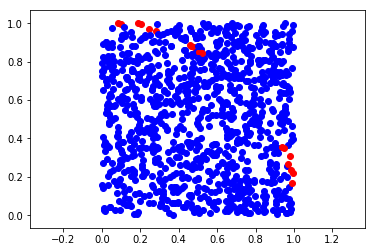

In [146]:
from scipy import array_equiv
import matplotlib.pyplot as plt
for idx,point in enumerate(input_):
    plt.scatter(point[0],point[1], color = 'b'*array_equiv(Yp[idx,:],target_[idx,:]) + 'r'*(not array_equiv(Yp[idx,:],target_[idx,:])))

plt.xlim(0,1)
plt.ylim(0,1)
plt.axis('equal')
plt.show()